In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_predict, KFold, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from collections import Counter
from xgboost import XGBClassifier

In [26]:
# Importing dataset and separating labels

train_data = pd.read_csv("D:\ML\Datasets\emails.csv")
train_data = train_data.drop_duplicates(subset=['text'])
Y = train_data['spam']
train_data.drop(labels='spam', axis=1, inplace=True)
train_data['text'] = train_data['text'].str.replace('\d+', '')

In [27]:
train_data.head()

,text
0,Subject: naturally irresistible your corporate...
1,Subject: the stock trading gunslinger fanny i...
2,Subject: unbelievable new homes made easy im ...
3,Subject: color printing special request addi...
4,"Subject: do not have money , get software cds ..."


In [45]:
# Creating bag of words

vectorizer = CountVectorizer(stop_words=['subject'])
                             #, max_features=5000) 
                             #, strip_accents="unicode")
X = vectorizer.fit_transform(train_data.text)
features = vectorizer.get_feature_names() # to check feature names if required
X = X.toarray()
X.shape
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### Feature scaling:

In [29]:
X = StandardScaler().fit_transform(X)
np.mean(X), np.std(X)

(-9.774471321782623e-18, 0.9999999999999816)

#### Implementing PCA and converting normalised features into a table format:

In [41]:
pca_spam = PCA(n_components=1000)
principalComponents_spam = pca_spam.fit_transform(X)
feat_cols = ['principal component ' + str(i + 1) for i in range (principalComponents_spam.shape[1])]
principal_spam_Df = pd.DataFrame(data=principalComponents_spam, columns=feat_cols)
principal_spam_Df.head()

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10,...,principal component 991,principal component 992,principal component 993,principal component 994,principal component 995,principal component 996,principal component 997,principal component 998,principal component 999,principal component 1000
0,-1.558674,-1.110277,-0.207079,0.667832,-0.643762,-0.273966,-0.191961,0.416713,-0.250477,-0.640182,...,-0.092827,-0.134640,-0.118070,0.037697,-0.035711,0.197220,-0.244573,-0.017238,0.045968,-0.119016
1,-3.028479,-2.955322,-0.557559,2.908638,-1.322041,0.116352,-0.859542,0.788596,-0.196532,-0.285269,...,0.087961,-0.018650,-0.130346,0.100205,0.346920,-0.043629,0.031580,0.009630,-0.193251,-0.084518
2,-2.526475,-2.096221,-0.467766,2.049224,-0.935885,-0.128762,-0.612429,0.750124,-0.168625,-0.279716,...,-0.062123,-0.520658,-0.642943,-0.291398,0.410457,0.670408,-0.540421,-0.887811,0.568568,-1.377962
3,-2.837453,-2.221944,-0.473927,1.910358,-0.892489,-0.075118,-1.093675,0.323169,-0.178732,-0.713834,...,-11.141158,4.209872,-4.187997,-3.451872,4.640022,-5.378155,-0.455627,1.241300,2.939547,-3.210730
4,-2.261821,-2.546773,-0.536291,2.688066,-1.142498,-0.087040,-0.791075,0.491247,-0.202254,0.003967,...,-0.261102,-0.034840,0.612459,-0.299753,0.465935,0.373384,-0.035277,0.069370,-0.848062,-0.329822


In [31]:
# percentage of variance explained for each components.explained_variance_ratio is used to calculate the variance ratio
# between the first two components
#print('Explained variation per principal component : {}'.format(pca_spam.explained_variance_ratio_))

In [42]:
explained_variation_total = pca_spam.explained_variance_ratio_
#explained_variation_total.shape
print(np.sum(explained_variation_total))

0.7153520948014098


In [33]:
# creating dataframes

pca_feature = principal_spam_Df
pca_label = pd.DataFrame(data=list(Y), columns=['label'])

<Figure size 432x288 with 0 Axes>

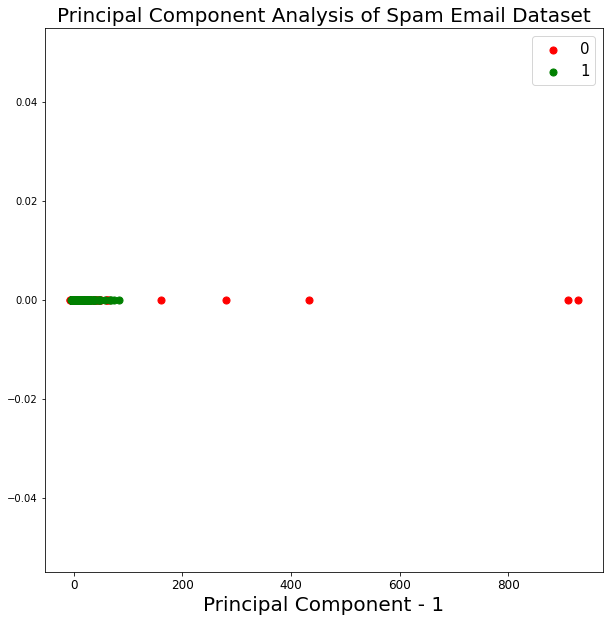

In [34]:
# visualizing the transformed variables by plotting the principal component

plt.figure()
plt.figure(figsize=(10, 10))
plt.xticks(fontsize=12)
plt.xlabel('Principal Component - 1', fontsize=20)
plt.title ("Principal Component Analysis of Spam Email Dataset", fontsize=20)
#targets=['Benign', 'Malignant']
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = pca_label['label'] == target
    y = np.zeros(pca_feature.loc[indicesToKeep, 'principal component 1'].shape)
    plt.scatter(pca_feature.loc[indicesToKeep,'principal component 1'], y, c=color, s=50)
plt.legend(targets, prop={'size': 15})
plt.show()

In [14]:
# Specifying model and KFold parameters

model = XGBClassifier(n_estimators=50, scale_pos_weight=3, max_depth=8, learning_rate=0.3, verbosity=0, random_state=1
                      , reg_alpha=5, reg_lambda=0, use_label_encoder=False)
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [15]:
# Making Predictions

predictions = cross_val_predict(model, X, y, cv=cv)

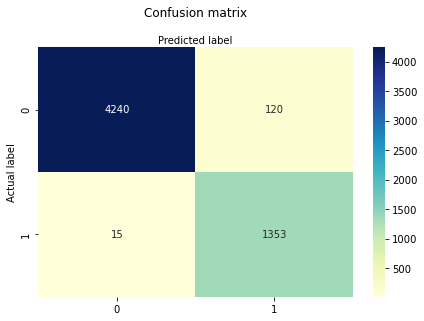

In [16]:
# Printing confusion matrix in the colored format seen below in output

cm = confusion_matrix(y, predictions)
class_names = [0, 1] # names of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Creating heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
# Printing classification report

print("Classification Report:")
print(classification_report(y, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4360
           1       0.92      0.99      0.95      1368

    accuracy                           0.98      5728
   macro avg       0.96      0.98      0.97      5728
weighted avg       0.98      0.98      0.98      5728



In [18]:
scores = cross_validate(model, X, y, cv=cv, scoring=('accuracy', 'precision', 'recall', 'roc_auc'), return_train_score=True)
#print(scores.keys()) # to obtain dict keys

In [19]:
mean_train_acc = round(np.mean((scores['train_accuracy'])), 2)
mean_test_acc = round(np.mean((scores['test_accuracy'])), 2)
mean_train_prec = round(np.mean((scores['train_precision'])), 2)
mean_test_prec = round(np.mean((scores['test_precision'])), 2)
mean_train_rec = round(np.mean((scores['train_recall'])), 2)
mean_test_rec = round(np.mean((scores['test_recall'])), 2)
mean_train_roc_auc = round(np.mean((scores['train_roc_auc']), dtype=np.float64), 2)
mean_test_roc_auc = round(np.mean((scores['test_roc_auc']), dtype=np.float64), 2)
print("Mean accuracy score (training): {0:.2f}".format(mean_train_acc))
print("Mean accuracy score (testing): {0:.2f}".format(mean_test_acc))
print("Mean precision score (training): {0:.2f}".format(mean_train_prec))
print("Mean precision score (testing): {0:.2f}".format(mean_test_prec))
print("Mean recall score (training): {0:.2f}".format(mean_train_rec))
print("Mean recall score (testing): {0:.2f}".format(mean_test_rec))
print("Mean ROC AUC score (training): {0:.2f}".format(mean_train_roc_auc))
print("Mean ROC AUC score (testing): {0:.2f}".format(mean_test_roc_auc))

Mean accuracy score (training): 0.99
Mean accuracy score (testing): 0.98
Mean precision score (training): 0.97
Mean precision score (testing): 0.92
Mean recall score (training): 1.00
Mean recall score (testing): 0.99
Mean ROC AUC score (training): 1.00
Mean ROC AUC score (testing): 1.00


In [20]:
FPR = 123 / (123 + 4237) # FP / FP + TN
FNR = 20 / (20 + 1348) # FN / FN + TP
TNR = 4237 / (4273 + 123) # TN / TN + FP (Specificity)
TPR = 1348 / (1348 + 20)
print("False Positive Rate (testing): {0:.2f}".format(FPR))
print("False Negative Rate (testing): {0:.2f}".format(FNR))
print("Specificity (testing): {0:.2f}".format(TNR))
print("Sensitivity (testing): {0:.2f}".format(TPR))

False Positive Rate (testing): 0.03
False Negative Rate (testing): 0.01
Specificity (testing): 0.96
Sensitivity (testing): 0.99
